In [2]:
import numpy as np
#import matplotlib.pyplot as plt
#%matplotlib inline 
from SEDFit.sed import SEDFit
from astropy.table import Table


def read_ogle(filename):
    # NOTE: need to apply diff dist moduli 
    def get_loc(name):
        return name[5:8]
    get_loc=np.vectorize(get_loc)


    hb = Table.read(filename,header_start=6,data_start=7,format='ascii')
    hb['loc'] = get_loc(hb['ID'])
    return hb

def do_lmcsmc_fit(ra,dec, wise=False,tmass=True,gal='LMC',AA_cut_IR=1e99,ID=None):
    radius = 1 #arcsec
    if gal=='LMC':
        print("Fitting for LMC location")
        mydist = 49.97e3 #pc
        myfeh  = -0.42 #dex
    elif gal=='SMC':
        print("Fitting for SMC location")
        mydist = 62.44e3 #pc
        myfeh = -0.94
    else:
        print("galaxy not recognized (LMC,SMC) are options, entered:",gal)
        return
    
    crd=(str(ra)+'_'+str(dec)+'_'+str(radius)).replace(':','_')
    if ID is None:
        flux_filename=crd+'_sed.csv'
        plot_filename=crd+'_sedplot.pdf'
    else:
        flux_filename=ID+'_sed.csv'
        plot_filename=ID+'_sedplot.pdf'
    print("Saving output to:",flux_filename,plot_filename)
    
    # setup, add guesses 
    x=SEDFit(ra, dec,radius,use_gaia_params=False,download_flux=True,wise=wise,tmass=tmass,flux_filename=flux_filename)
    x.addguesses(r=[30],teff=[30000],logg=3,dist=mydist,feh=myfeh)
    x.addrange(logg=[0,4],dist=[mydist-1e-3,mydist+1e-3] )
    # choose which filters to use
    use_idx = np.where(x.sed['la']<AA_cut_IR)[0]
    x.fit( use_mag = use_idx , fitfeh=False) 
    x.chi2oN = x.getchisq(idx=use_idx)
    print("Distance: {} pc".format(x.getdist()))
    print("AV: {} mag".format(x.getav()))
    print("Radius: {} Rsun".format(x.getr()))
    print("Teff: {} K".format(x.getteff()))
    print("Log g: {} ".format(x.getlogg()))
    print("Fe/H: {}".format(x.getfeh()))
    print("Chi squared/N: {}".format( x.chi2oN )  )
    
    x.makeplot(file=plot_filename,idx=use_idx,title=ID)
    x.sed['model']=x.mags
    #x.sed
    
    return x 
    
    
## EXAMPLE
#do_lmcsmc_fit('81.60188','-68.784722',gal='LMC',wise=True,tmass=False,AA_cut_IR=2e4,ID='test')

========= i= 0 ============================================
Fitting for LMC location
Saving output to: OGLE-LMC-HB-0001_sed.csv OGLE-LMC-HB-0001_sedplot.pdf
Gaia parallax is not available, distance is arbitrarily set by default and should be manually adjusted.
Maximum Av along the line of sight is 0.255
Distance: 49970.000599790874 pc
AV: 0.2545723000117352 mag
Radius: [40.221389032227606] Rsun
Teff: [4652.420133697741] K
Log g: [3.499919522536351] 
Fe/H: -0.42
Chi squared/N: 26.959309661088483


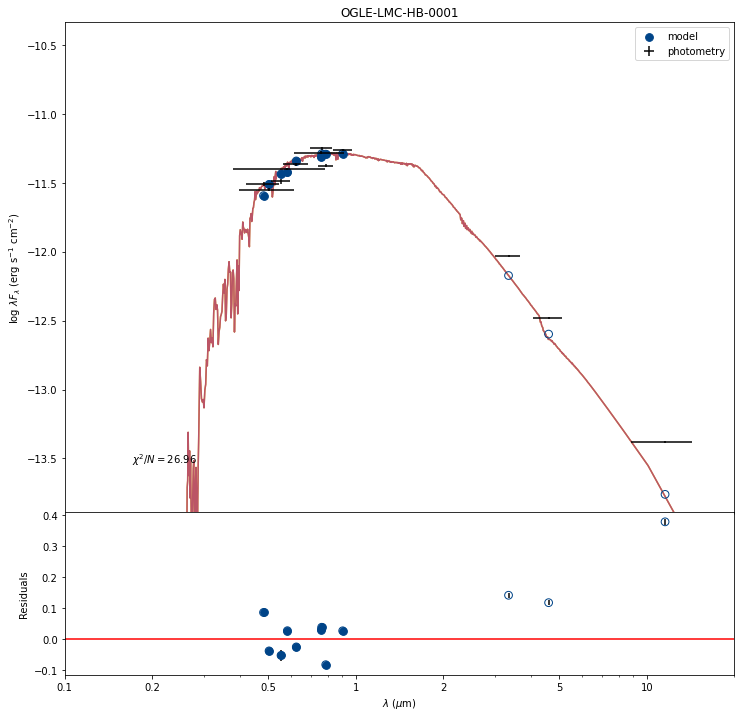

========= i= 1 ============================================
Fitting for LMC location
Saving output to: OGLE-LMC-HB-0002_sed.csv OGLE-LMC-HB-0002_sedplot.pdf
Gaia parallax is not available, distance is arbitrarily set by default and should be manually adjusted.
Maximum Av along the line of sight is 0.322
Distance: 49970.00065555175 pc
AV: 0.3215307967747722 mag
Radius: [31.298149285309844] Rsun
Teff: [4566.686156460895] K
Log g: [3.4999884668711245] 
Fe/H: -0.42
Chi squared/N: 12.253442759437782


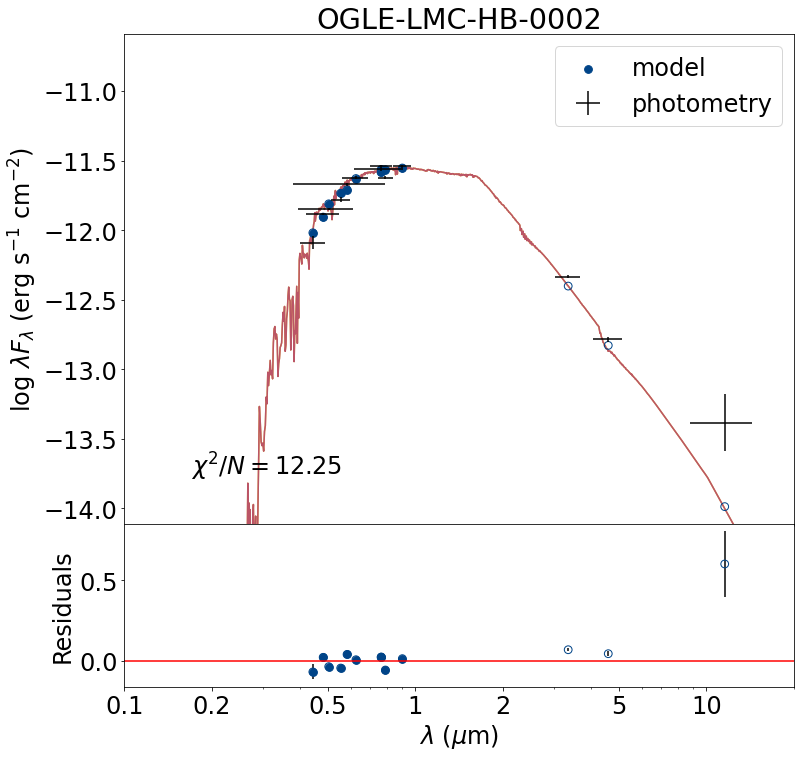

========= i= 2 ============================================
Fitting for LMC location
Saving output to: OGLE-LMC-HB-0003_sed.csv OGLE-LMC-HB-0003_sedplot.pdf
Gaia parallax is not available, distance is arbitrarily set by default and should be manually adjusted.
Maximum Av along the line of sight is 0.968
Distance: 49970.00062147906 pc
AV: 0.16239328749378687 mag
Radius: [7.758986442516314] Rsun
Teff: [16381.343935824621] K
Log g: [2.451850808936714] 
Fe/H: -0.42
Chi squared/N: 18.6350363919978


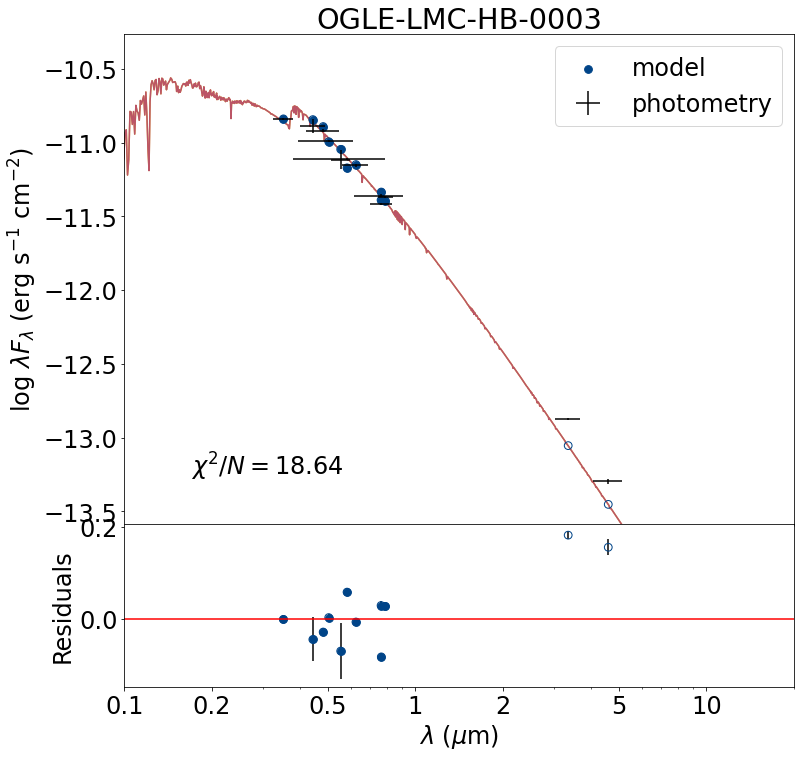

OSError: File ogle_hb_sedfit.csv already exists. If you mean to replace it then use the argument "overwrite=True".

In [2]:
# Read and select LMC, SMC
hb = read_ogle("../query_1683478037.14515r.txt")
hb = hb[hb['loc']!='BLG'].copy()
hb[0:2]

#initialize new columns
hb['sed_dist'] = 0.0
hb['sed_av'] = 0.0
hb['sed_radius']=0.0
hb['sed_teff'] = 0.0
hb['sed_logg'] = 0.0
hb['sed_feh'] = 0.0
hb['sed_chi2oN'] = 0.0

# do fitting 
for i in range(3):
    print("========= i=",i,"============================================")
    x=do_lmcsmc_fit(hb['RA'][i],hb['Decl'][i],gal=hb['loc'][i],ID=hb['ID'][i],
                    wise=True,tmass=False,AA_cut_IR=2e4)
    hb['sed_dist'][i] = x.getdist()
    hb['sed_av'][i] = x.getav()
    hb['sed_radius'][i] = x.getr()[0]
    hb['sed_teff'][i] = x.getteff()[0]
    hb['sed_logg'][i] = x.getlogg()[0]
    hb['sed_feh'][i] = x.getfeh()
    hb['sed_chi2oN'][i] = x.chi2oN

# write the output
hb.write('ogle_hb_sedfit.csv',overwrite=False)

In [8]:
hb = Table.read("ogle_hb_sedfit.csv")

In [6]:
vot = Table.read("OGLE-LMC-HB-0254_vizier_sed.vot")

print( np.unique( vot['sed_filter'] ).value )

['2MASS:H' '2MASS:J' '2MASS:Ks' ':=1.250um' ':=1.65um' ':=2.17um'
 ':=3.6um' ':=4.5um' ':=5.8um' ':=8um' 'AKARI:N3' 'Cousins:B' 'Cousins:I'
 'Cousins:R' 'Cousins:U' 'Cousins:V' 'GAIA/GAIA2:G' 'GAIA/GAIA2:Gbp'
 'GAIA/GAIA2:Grp' 'GAIA/GAIA3:G' 'GAIA/GAIA3:Gbp' 'GAIA/GAIA3:Grp'
 'Gaia:G' 'Johnson:B' 'Johnson:H' 'Johnson:J' 'Johnson:K' 'Johnson:V'
 'POSS-II:F' 'SDSS:g' 'SDSS:i' 'SDSS:r' 'SDSS:u' 'SDSS:z'
 'SkyMapper/SkyMapper:g' 'SkyMapper/SkyMapper:i' 'SkyMapper/SkyMapper:r'
 'SkyMapper/SkyMapper:z' 'Spitzer/IRAC:3.6' 'Spitzer/IRAC:4.5'
 'Spitzer/IRAC:5.8' 'Spitzer/IRAC:8.0' 'VISTA:J' 'VISTA:Ks' 'VISTA:Y'
 'WISE:W1' 'WISE:W2' 'WISE:W3' 'WISE:W4']


In [9]:
hb[253]

ID,Type,RA,Decl,I,V,V_I,P,T0,A,Ecc,Incl,Peri,Model,loc,sed_dist,sed_av,sed_radius,sed_teff,sed_logg,sed_feh,sed_irslope,sed_chi2oN,Av_median,Av_minus_two_sigma,Av_plus_two_sigma,sed_L
str16,str2,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
OGLE-LMC-HB-0254,MS,05:26:24.45,-68:47:05.0,13.473,13.772,0.299,32.82939,9031.003,0.321,0.5473,42.51,130.64,1,LMC,49970.00000396949,0.5946280535786892,33.02823945110371,14000.000218207579,0.4697431722886831,-0.7,0.0746279579415242,1.2005526082339901,0.43425,0.0,1.09125,38045.36926169502


In [13]:
import wget

wget.download("https://vizier.cds.unistra.fr/viz-bin/sed?-c=73.93441666666666%20-68.71097222222222&-c.rs=0.5",out='')

'vizier_votable (1).vot'

In [14]:
Table.read('vizier_votable (1).vot')

_RAJ2000,_DEJ2000,_tabname,_ID,_tab1_31,_tab1_32,sed_freq,sed_flux,sed_eflux,sed_filter
deg,deg,,,d,,GHz,Jy,Jy,
float64,float64,str32,str64,float64,float64,float64,float32,float32,str32
73.934319400,-68.710916700,I/297/out,"NOMAD1===0212-0053841&-c=073.9343194 -68.7109167,eq=J2000&-c.rs=",--,0.0,181750,0.00365,--,2MASS:H
73.934319400,-68.710916700,I/297/out,"NOMAD1===0212-0053841&-c=073.9343194 -68.7109167,eq=J2000&-c.rs=",--,0.0,241960,0.0026,--,2MASS:J
73.934210000,-68.710915000,I/305/out,"GSC2.3===S1HH117261&-c=073.934210 -68.710915,eq=J2000&-c.rs=0.00",--,0.0,468430,0.000632,0.00026,POSS-II:F
73.934431080,-68.710993050,I/317/sample,"PPMXL=6651675152954032693&-c=073.934431 -68.710993,eq=J2000&-c.r",--,0.0,138550,0.00275,0.00012,2MASS:Ks
73.934431080,-68.710993050,I/317/sample,"PPMXL=6651675152954032693&-c=073.934431 -68.710993,eq=J2000&-c.r",--,0.0,181750,0.00364,0.00014,2MASS:H
73.934431080,-68.710993050,I/317/sample,"PPMXL=6651675152954032693&-c=073.934431 -68.710993,eq=J2000&-c.r",--,0.0,241960,0.0026,8e-05,2MASS:J
73.934432980,-68.710991980,I/319/xpm,"-c=073.934433 -68.710992,eq=ICRS&-c.rs=0.004",--,0.0,138550,0.00275,0.00012,2MASS:Ks
73.934432980,-68.710991980,I/319/xpm,"-c=073.934433 -68.710992,eq=ICRS&-c.rs=0.004",--,0.0,181750,0.00364,0.00014,2MASS:H


In [15]:
wget.download?

In [41]:
vot = Table.read('OGLE-SMC-HB-0037_vizier_sed.vot')
sel = vot['sed_filter']=='XMM-OT:UVW2'

vot[sel]

_RAJ2000,_DEJ2000,_tabname,_ID,_tab1_66,_tab1_67,sed_freq,sed_flux,sed_eflux,sed_filter
deg,deg,,,d,,GHz,Jy,Jy,
float64,float64,str32,str64,float64,float64,float64,float32,float32,str32


In [301]:
from astropy.table import Table
hb=Table.read('ogle_hb_sedfit.csv')
hb.keys()

['ID',
 'Type',
 'RA',
 'Decl',
 'I',
 'V',
 'V_I',
 'P',
 'T0',
 'A',
 'Ecc',
 'Incl',
 'Peri',
 'Model',
 'loc',
 'sed_dist',
 'sed_av',
 'sed_radius',
 'sed_teff',
 'sed_logg',
 'sed_feh',
 'sed_irslope',
 'sed_chi2oN',
 'Av_median',
 'Av_minus_two_sigma',
 'Av_plus_two_sigma',
 'sed_L']

(100000.0, 1000.0)

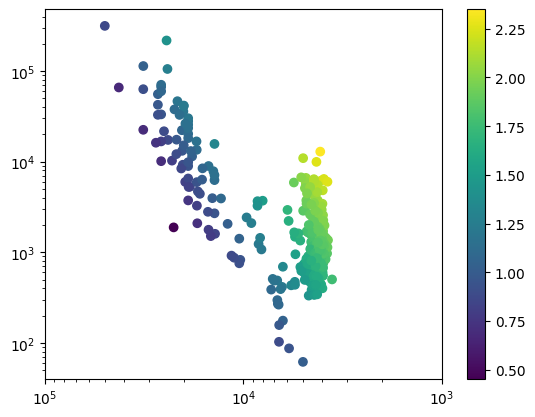

In [302]:
import matplotlib.pyplot as plt
plt.scatter(hb['sed_teff'],hb['sed_L'],c=np.log10(hb['sed_radius']) )
plt.colorbar()
plt.loglog()
plt.xlim(1e5,1e3)

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_50064/4012595059.py:6: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(xp,np.sqrt(1-(p0/xp)**(2/3.)),ls='--',color='grey',zorder=0 )


(2, 2000)

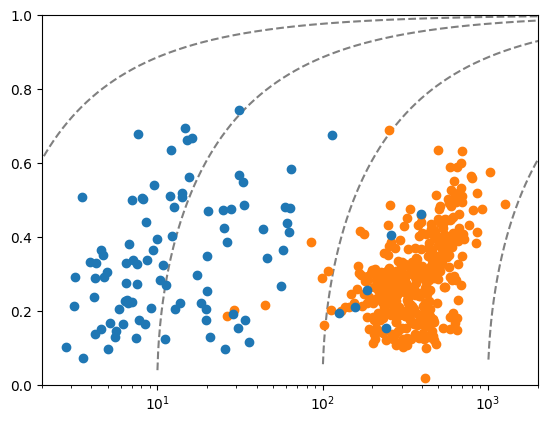

In [303]:
selc = hb['sed_teff']<6250.
plt.scatter(hb['P'][selc],hb['Ecc'][selc],c='C1' )
plt.scatter(hb['P'][selc==False],hb['Ecc'][selc==False],c='C0' )
xp = np.logspace(0,4,1000)
for p0 in np.logspace(0,3,4):
    plt.plot(xp,np.sqrt(1-(p0/xp)**(2/3.)),ls='--',color='grey',zorder=0 )
plt.semilogx()
plt.ylim(0,1)
plt.xlim(2,2000)

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_50064/4100464053.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(xp,np.sqrt(1-(p0/xp)**(2/3.)),ls='--',color='grey',zorder=0 )


(2, 2000)

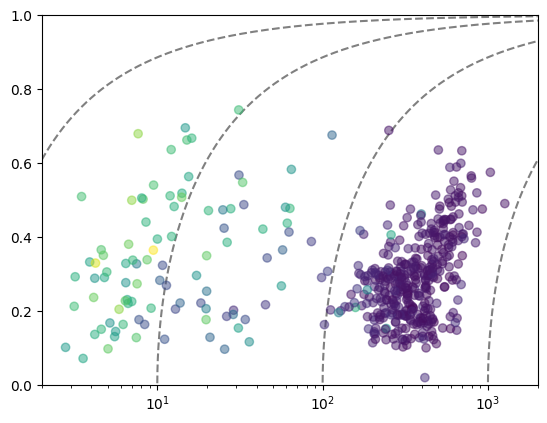

In [304]:
plt.scatter(hb['P'],hb['Ecc'],c=np.log10(hb['sed_teff']),alpha=0.5 )
xp = np.logspace(0,4,100000)
for p0 in np.logspace(0,3,4):
    plt.plot(xp,np.sqrt(1-(p0/xp)**(2/3.)),ls='--',color='grey',zorder=0 )
plt.semilogx()
plt.ylim(0,1)
plt.xlim(2,2000)

[]

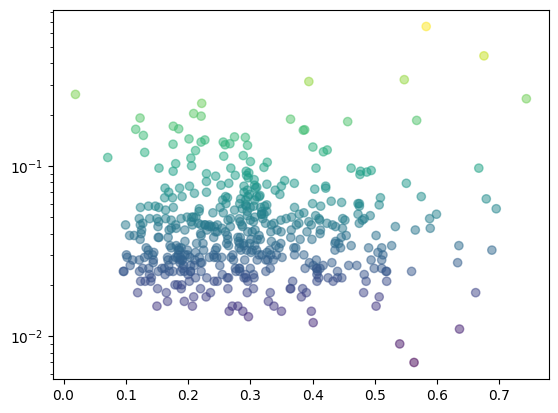

In [219]:
plt.scatter(hb['Ecc'],hb['A'],c=np.log10(hb['A']),alpha=0.5 )
plt.semilogy()

(-4.5, 0.24999999999999997)

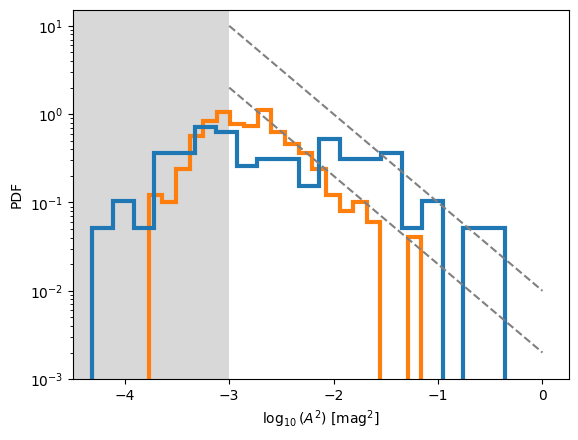

In [299]:
plt.hist(np.log10(hb['A'][selc]**2),bins=20,color='C1',histtype='step',lw=3,density=True)
plt.hist(np.log10(hb['A'][selc==False]**2),bins=20,color='C0',histtype='step',lw=3,density=True)
plt.semilogy()
xp = np.logspace(-3,0)
plt.plot(np.log10(xp),2e-3/xp,color='grey',ls='--')
plt.plot(np.log10(xp),1e-2/xp,color='grey',ls='--')
plt.ylim(1e-3,)

plt.xlabel(r'$\log_{10}\left(A^2 \right)$ [mag$^2$]')
plt.ylabel('PDF')

plt.axvspan(-3, -5, facecolor='grey', alpha=0.3,edgecolor='none')
plt.xlim(-4.5,)

(-4.5, -0.13034062935257928)

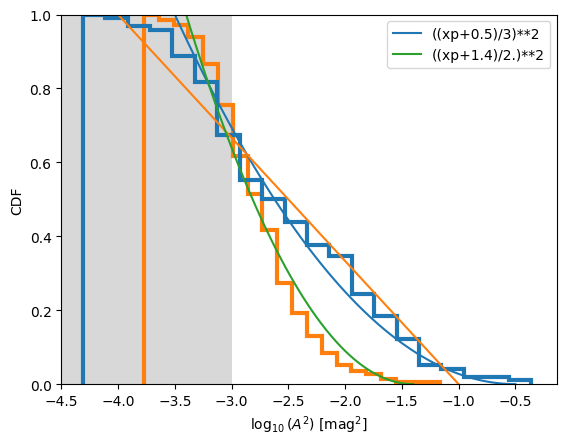

In [274]:
plt.hist(np.log10(hb['A'][selc]**2),bins=20,color='C1',histtype='step',lw=3,
         density=True,cumulative=-1)
plt.hist(np.log10(hb['A'][selc==False]**2),bins=20,color='C0',histtype='step',lw=3,
         density=True,cumulative=-1)

plt.xlabel(r'$\log_{10}\left(A^2 \right)$ [mag$^2$]')
plt.ylabel('CDF')

xp=np.linspace(-0.5,-4,100)
plt.plot(xp,((xp+0.5)/3)**2,label="((xp+0.5)/3)**2" )
plt.plot(xp,-(xp+1)/3)
xp=np.linspace(-1.4,-4,100)
plt.plot(xp,((xp+1.4)/2.)**2,label='((xp+1.4)/2.)**2' )
plt.legend()

plt.ylim(0,1)
plt.axvspan(-3, -5, facecolor='grey', alpha=0.3,edgecolor='none')
plt.xlim(-4.5,)

(array([0.79381443, 0.88659794, 0.94845361, 0.94845361, 0.95876289,
        0.95876289, 0.97938144, 0.97938144, 0.97938144, 0.97938144,
        0.97938144, 0.97938144, 0.97938144, 0.98969072, 0.98969072,
        0.98969072, 0.98969072, 0.98969072, 0.98969072, 0.98969072,
        0.98969072, 0.98969072, 0.98969072, 0.98969072, 0.98969072,
        0.98969072, 0.98969072, 0.98969072, 0.98969072, 1.        ]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x2889f8760>])

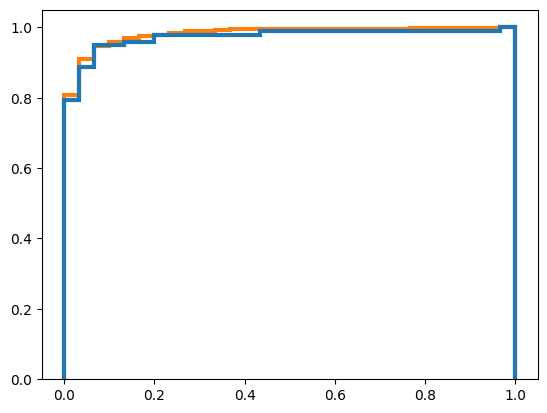

In [207]:
# renormalize the distributions... 

Aremap_cool = hb['A'][selc]
Aremap_hot  = hb['A'][selc==False]

Aremap_cool = (Aremap_cool-np.min(Aremap_cool))/(np.max(Aremap_cool) - np.min(Aremap_cool))
Aremap_hot = (Aremap_hot-np.min(Aremap_hot))/(np.max(Aremap_hot) - np.min(Aremap_hot))


plt.hist(Aremap_cool**2,histtype="step",lw=3,color='C1',bins=30,cumulative=True,density=True)
plt.hist(Aremap_hot**2,histtype="step",lw=3,color='C0',bins=30,cumulative=True,density=True)


In [211]:
from scipy import stats

# Test if the two samples are drawn from the same distribution
stats.ks_2samp(hb['A'][selc],hb['A'][selc==False])
#stats.ks_2samp(Aremap_cool,Aremap_hot)


KstestResult(statistic=0.27999676148324065, pvalue=7.470091062378448e-06, statistic_location=0.088, statistic_sign=1)

In [212]:
from scipy.stats import anderson_ksamp

# Perform the Anderson-Darling test
statistic, critical_values, significance_level = anderson_ksamp([hb['A'][selc],hb['A'][selc==False]])
#statistic, critical_values, significance_level = anderson_ksamp([Aremap_cool,Aremap_hot])

print("Anderson-Darling statistic:", statistic)
print("Critical values:", critical_values)
print("Significance level:", significance_level)

if statistic > critical_values[0]:
    print("Reject the null hypothesis: the two distributions are not the same.")
else:
    print("Cannot reject the null hypothesis: the two distributions may be the same.")

Anderson-Darling statistic: 16.033007054300242
Critical values: [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
Significance level: 0.001
Reject the null hypothesis: the two distributions are not the same.


/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_50064/327167542.py:4: UserWarning: p-value floored: true value smaller than 0.001
  statistic, critical_values, significance_level = anderson_ksamp([hb['A'][selc],hb['A'][selc==False]])


(20.0, 12.0)

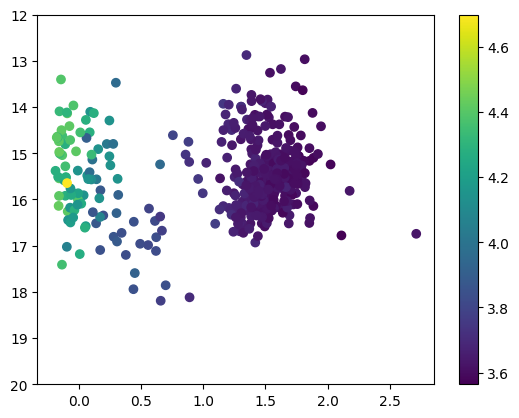

In [8]:
plt.scatter(hb['V']-hb['I'],hb['I'],c=np.log10(hb['sed_teff']) )
plt.colorbar()
plt.ylim(20,12)


In [71]:
hb=Table.read('ogle_hb_sedfit.csv')

In [50]:
hb[['RA','Decl']].write('ogle_hb_radec.txt',overwrite=True,delimiter=' ',format='ascii')

In [62]:
ext = Table.read('ogle_ext.txt',format='ascii')

(array([ 1.,  1.,  1.,  1.,  4.,  7.,  9., 12., 19., 23., 33., 28., 30.,
        45., 53., 24., 33., 38., 30., 13., 17., 14., 18.,  7.,  7.,  3.,
         4.,  2.,  1.,  1.]),
 array([-1.17950963, -1.12848612, -1.07746261, -1.02643911, -0.9754156 ,
        -0.92439209, -0.87336859, -0.82234508, -0.77132157, -0.72029807,
        -0.66927456, -0.61825105, -0.56722755, -0.51620404, -0.46518053,
        -0.41415703, -0.36313352, -0.31211001, -0.26108651, -0.210063  ,
        -0.15903949, -0.10801599, -0.05699248, -0.00596897,  0.04505453,
         0.09607804,  0.14710155,  0.19812505,  0.24914856,  0.30017207,
         0.35119558]),
 <BarContainer object of 30 artists>)

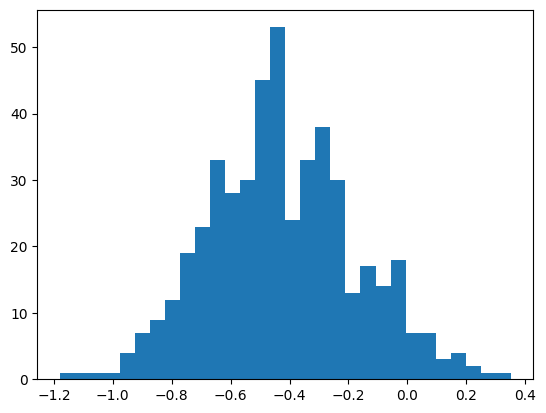

In [305]:
plt.hist( np.log10( hb['sed_chi2oN']),bins=30 )

1.7782794100389228

In [80]:
np.log10( 6.67e-8*20*2e33/(50*7e10)**2 )

2.33804973654396

In [1]:
Table.read("OGLE-LMC-HB-0254_vizier_sed.vot")

NameError: name 'Table' is not defined